# Upper ocean effects of windmill farms at sea - Sørvest F 
### Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute

#### The project

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 6 (?) different farms along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 3 x ? turbines

### Calculation of mean internal Rossby radius

To investigate the impact of wind farms at sea it is useful to make the study area smaller, i.e. not use the whole model domain. The Rossby radius or deformation radius allows us to delimit the area safely while making sure that the relevant dynamics are still within the domain. By taking 1-2 deformation radii as our domain of investigation around the wind farm, we're making sure that the internal dynamics are dominated by internal baroclinic instabilities. As the radius is telling about the length of deformation of a wave, that is a length scaale where the rotation of Earth affects the currents and geostrophy dominates.

Sperrevik et al. (2017) calculated the internal Rossby radii using the following method.

$$R_1 = \frac{c_1}{\mid f \mid}$$
where $f$ is the local Coriolis parameter and $c_1$ the phase speed of a first mode baroclinic gravity wave. The phase speed can be solved as an eigenvalue problem, but we will deploy the method of Chelton et al. (1998) and use the WKB-approximation.
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Here, $H$ is the local water depth and $N$ the buoyancy frequency. Sperrevik et al. (2017) calculated the radius for an area in Northern Norway, Lofoten, as shown in the figure below.

<p align="center">
  <img src="Sperrevik_etal_2017_fig5.png" alt="Sperrevik et al. (2017)">
</p>

Here we have the internal deformation radius for the spring months of 1984. The radii has its minimum after the winter and increases towards the summer due to a stronger stratification developing. I will use this figure as a reference to see if the values I compute are reasonable.

In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import cartopy.crs as ccrs
import pandas as pd
from roppy import SGrid

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
path = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/norkyst_avg_0001DENSITY_USED.nc'
ds_density = xr.open_dataset(path)

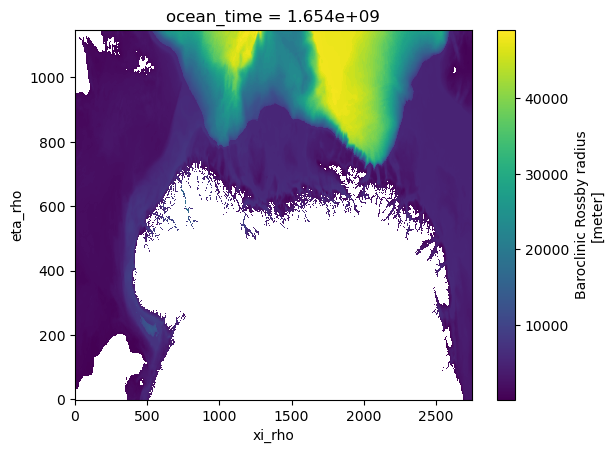

In [22]:
ds_density.gamma_r.isel(ocean_time=0).plot()

In [23]:
path0 = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/norkyst_avg_0001ANNKS_METHOD.nc'
ds_annks = xr.open_dataset(path0)

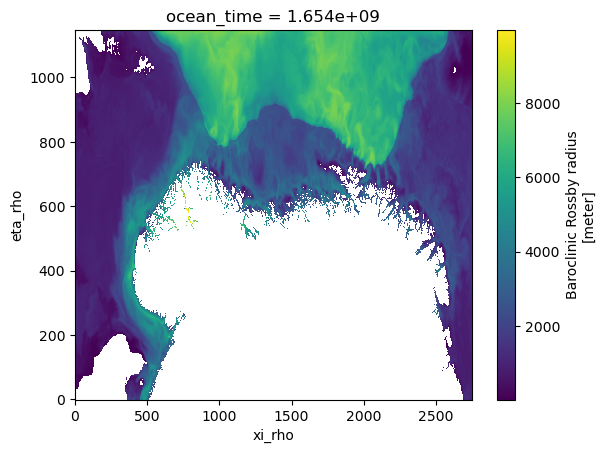

In [24]:
ds_annks.gamma_r.isel(ocean_time=0).plot()

In [25]:
path1 = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/norkyst_avg_0001NEWTRYZLEVS.nc'
ds_zlevs_changed = xr.open_dataset(path1)

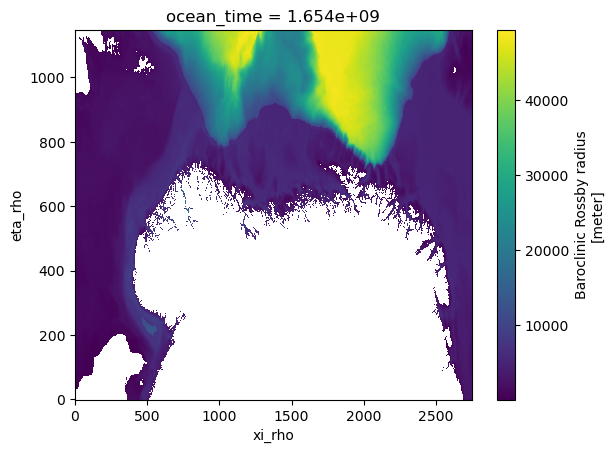

In [26]:
ds_zlevs_changed.gamma_r.isel(ocean_time=0).plot()

In [52]:
from roppy import SGrid
from netCDF4 import Dataset
import numpy as np
import matplotlib
matplotlib.use('Agg')
from roppy import SGrid
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import griddata
from glob import glob
from N2 import N2
import time
from density import dens

In [10]:
path1 = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-06/norkyst_avg_0001.nc'
ds1 = Dataset(path1)

NameError: name 'Dataset' is not defined

In [37]:
grid = SGrid(ds1)

In [53]:
zlevs = np.arange(0,51,1)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(52,102,2), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(105,305,5), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(520,1020,20), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(1050,3050,50), axis =0)

zlevs = zlevs[np.where(zlevs<=np.max(grid.h))]
zlevs = np.array(zlevs)*-1.

# Depth of rho-points
z_r = np.insert(grid.z_r, grid.z_r.shape[0], values = np.zeros_like(grid.h), axis=0)
z_r = np.insert(z_r, 0, values = -1.*grid.h, axis=0)

# Variables
ocean_time = ds1.variables['ocean_time']
density = ds1.variables['rho'][:]
salt  = ds1.variables['salt'][:]
temp = ds1.variables['temp'][:]
f = ds1.variables['f'][:]
h = grid.h[:,:]
mask = grid.mask_rho[:,:]

tmpn = np.ones([1, density.shape[2], density.shape[3]])*np.nan  # Temporary array holding buoyancy frequency
tmpr = np.ones([1, density.shape[2], density.shape[3]])*np.nan  # Temporary array holding Rossby radius

# Looping through grid points
for y in range(0, density.shape[2]):
    for x in range(0, density.shape[3]): 
        if not mask[y, x]:  # skipping land points
            continue

        tmpn[0,y,x] = 0
        tmpnz = zlevs[np.where(zlevs[:]>z_r[:,y,x].min())].squeeze()  # z-levels to calculate N on
        N_depth = (tmpnz[0:-1] + tmpnz[1:])/2.  # Midpoints between z-levels

        if 1:
            t = -1
            tmpnS = salt[t,:,y,x]; tmpnS = np.append(tmpnS,tmpnS[-1]); tmpnS = np.insert(tmpnS,0,values=tmpnS[0],axis=0)
            tmpnT = temp[t,:,y,x]; tmpnT = np.append(tmpnT,tmpnT[-1]); tmpnT = np.insert(tmpnT,0,values=tmpnT[0],axis=0)
            tempZ = griddata(z_r[:,y,x], tmpnT[:], tmpnz)
            saltZ = griddata(z_r[:,y,x], tmpnS[:], tmpnz)

            tmpD =  density[t, :, y, x]
            tmpD = np.append(tmpD, tmpD[-1]); tmpD = np.insert(tmpD, 0, values=tmpD[0], axis=0)
            #densZ = griddata(z_r[:, y, x], tmpD[:], tmpnz) 

            densm = dens(saltZ, tempZ, np.zeros_like(tempZ)).squeeze()

In [54]:
densm

array([1027.70674997, 1027.70675167, 1027.70649519, 1027.70524111,
       1027.70778563, 1027.70895758, 1027.70978039, 1027.71049097,
       1027.71167721, 1027.71345494, 1027.71705409, 1027.72147375,
       1027.72407478, 1027.72607602, 1027.72791578, 1027.73026373,
       1027.73282177, 1027.7356854 , 1027.73857399, 1027.74147745,
       1027.7441132 , 1027.74653082, 1027.74886781, 1027.75108643,
       1027.75328576, 1027.75533822, 1027.75737588, 1027.75932019,
       1027.76115644, 1027.76298062, 1027.76432967, 1027.76543663,
       1027.76654057, 1027.76769703, 1027.76888558, 1027.77007178,
       1027.77116702, 1027.77204369, 1027.77291923, 1027.77379363,
       1027.77471471, 1027.77566035, 1027.77660488, 1027.77754831,
       1027.77839336, 1027.77918902, 1027.77998423, 1027.78077899,
       1027.78151833, 1027.78213058, 1027.78274277, 1027.78396702,
       1027.78470324, 1027.78528469, 1027.78592759, 1027.78691886,
       1027.78790702, 1027.78882526, 1027.78959941, 1027.79036

In [9]:
ds1.variables['rho']

KeyError: 'rho'